In [1]:
INPUT_DATASET_DIR = '../HyperpartisanNewsCorpora/pan19-hyperpartisan-news-detection-by-article-training-dataset-2018-11-22/'
GROUND_TRUTH_DIR  = '../HyperpartisanNewsCorpora/pan19-hyperpartisan-news-detection-by-article-training-dataset-2018-11-22/ground-truth/'

In [2]:
import os, sys
import xml.sax

In [3]:
## SAX parser for Hyperpartisan News XML
import lxml.sax, lxml.etree
import re

class HyperpartisanNewsExtractor(xml.sax.ContentHandler):
    """
    Parsing xml units with xml.sax + lxml.sax.ElementTreeContentHandler.
    Parser used in ../scripts/semeval-pan-2019-tf-extractor.py
    """
    
    def __init__(self):
        super().__init__()
        self.articles = list()
        self.lxmlhandler = None

    def startElement(self, name, attrs):
        if name != 'articles':
            if name == 'article':
                self.lxmlhandler = lxml.sax.ElementTreeContentHandler()
            self.lxmlhandler.startElement(name, attrs)

    def characters(self, data):
        if self.lxmlhandler is not None:
            self.lxmlhandler.characters(data)

    def endElement(self, name):
        if self.lxmlhandler is not None:
            self.lxmlhandler.endElement(name)
            if name == 'article':
                # pass to handleNewsArticle function
                self.articles.append(NewsArticle(self.lxmlhandler.etree.getroot()))
                self.lxmlhandler = None
                
'''
class NewsArticle:
    def __init__(self, rootNode):
        self.root = rootNode
        self.text = lxml.etree.tostring(rootNode, method="text", encoding="unicode")
        
        self.hyperpartisan = None
        self.bias = None
    
    def get_id(self):
        return self.root.get('id')
    
    def get_title(self):
        return self.root.get('title')
    
    def get_text(self):
        return self.text
    
    def get_text_cleaned(self):
        return re.sub('[^A-Za-z ]', '', self.text)
    
    def set_ground_truth(self, hyperpartisan, bias):
        self.hyperpartisan = hyperpartisan
        self.bias = bias
'''

'\nclass NewsArticle:\n    def __init__(self, rootNode):\n        self.root = rootNode\n        self.text = lxml.etree.tostring(rootNode, method="text", encoding="unicode")\n        \n        self.hyperpartisan = None\n        self.bias = None\n    \n    def get_id(self):\n        return self.root.get(\'id\')\n    \n    def get_title(self):\n        return self.root.get(\'title\')\n    \n    def get_text(self):\n        return self.text\n    \n    def get_text_cleaned(self):\n        return re.sub(\'[^A-Za-z ]\', \'\', self.text)\n    \n    def set_ground_truth(self, hyperpartisan, bias):\n        self.hyperpartisan = hyperpartisan\n        self.bias = bias\n'

In [4]:
class NewsArticle:
    """
    Class representing a single News article from the Hyperpartisan News Corpora.
    """

    # Pattern for replacing non-breaking spaces
    txt_tospace1 = re.compile(r'&#160;')

    # Pattern for replacing numbers
    number_pattern = re.compile(r'([\d]+[\.,]?[\d]*)')

    # Token for representing numbers
    NUMBER_TOKEN = '<num>'

    def __init__(self, rootNode):
        self.root = rootNode
        self.text = ' '.join([lxml.etree.tostring(el, method='text', encoding='unicode', with_tail=False).strip() \
                              for el in self.root.getiterator(tag='p')])

        self.hyperpartisan = None
        self.bias = None
    
    def get_id(self):
        return self.root.get('id')
    
    def get_title(self):
        return self.clean_text(self.root.get('title'))
    
    def get_text(self):
        return self.clean_text(self.text)

    def get_text_preprocessed(self):
        return self.preprocess_text(self.get_text())

    def get_text_alpha(self):
        return re.sub('[^A-Za-z ]', '', self.text)
    
    def set_ground_truth(self, hyperpartisan, bias):
        self.hyperpartisan = hyperpartisan
        self.bias = bias

    def get_hyperpartisan(self) -> str:
        ## May be None if not yet paired with ground-truth
        return self.hyperpartisan

    def is_hyperpartisan(self) -> bool:
        return self.get_hyperpartisan() == 'true'

    def get_bias(self) -> str:
        ## May be None if dataset was labeled by article (not by publisher)
        return self.bias

    def get_links(self):
        return self.root.iterdescendants(tag='a')


    @classmethod
    def clean_text(cls, text):
        """Clean the text extracted from XML."""
        text = text.replace("&amp;", "&")
        text = text.replace("&gt;", ">")
        text = text.replace("&lt;", "<")
        text = text.replace("<p>", " ")
        text = text.replace("</p>", " ")
        text = text.replace(" _", " ")
        text = text.replace("–", "-")
        text = text.replace("”", "\"")
        text = text.replace("“", "\"")
        text = text.replace("’", "'")
        text = text.replace("\t", " ")
        text = text.replace("⚪", " ")
        text = text.replace("  ", " ")

        text = cls.txt_tospace1.sub(' ', text)
        return text

    @classmethod
    def preprocess_text(cls, text):
        ## Substitute numbers with a special token
        text = cls.number_pattern.sub(cls.NUMBER_TOKEN, text)
        return text

In [5]:
news_content_handler = HyperpartisanNewsExtractor()

for file in os.listdir(INPUT_DATASET_DIR):
    if file.endswith('xml'):
        with open(INPUT_DATASET_DIR + '/' + file, 'r', encoding='utf-8') as inputfile:
            parser = xml.sax.make_parser()
            parser.setContentHandler(news_content_handler)
            source = xml.sax.xmlreader.InputSource()
            source.setByteStream(inputfile)
            source.setEncoding('utf-8')
            parser.parse(source)
            
articles = news_content_handler.articles

In [6]:
## SAX parser for Ground Truth XML
class HyperpartisanNewsGroundTruthExtractor(xml.sax.ContentHandler):
    """
    SAX parser for ground truth XML.
    """
    def __init__(self):
        super().__init__()
        self.hyperpartisan = dict()
        #self.bias = dict()

    def startElement(self, name, attrs):
        if name == 'article':
            article_id = attrs.getValue('id')
            hyperpartisan = attrs.getValue('hyperpartisan')
            self.hyperpartisan[article_id] = hyperpartisan
#            bias = attrs.getValue('bias')
#            self.bias[article_id] = bias

In [7]:
truth_content_handler = HyperpartisanNewsGroundTruthExtractor()

for file in os.listdir(GROUND_TRUTH_DIR):
    if file.endswith('xml'):
        with open(GROUND_TRUTH_DIR + '/' + file, 'r', encoding='utf-8') as inputfile:
            parser = xml.sax.make_parser()
            parser.setContentHandler(truth_content_handler)
            source = xml.sax.xmlreader.InputSource()
            source.setByteStream(inputfile)
            source.setEncoding('utf-8')
            parser.parse(source)

In [8]:
for i in range(len(articles)):
    article_id = articles[i].get_id()
    articles[i].set_ground_truth(
        truth_content_handler.hyperpartisan[article_id],
        None # truth_content_handler.bias[article_id]
    )

In [9]:
## Extract sentence length distribution, number of links per article distribution, term frequency
### All plots Hyperpartisan VS Non-Hyperpartisan [VS Left VS Right]
hyperpartisan = [a for a in articles if a.hyperpartisan == 'true']
mainstream = [a for a in articles if a.hyperpartisan == 'false']

In [10]:
import spacy
import nltk
from flair.data import Sentence
from nltk.tokenize import sent_tokenize

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'tagger'])
nlp.add_pipe(nlp.create_pipe('sentencizer'))

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [11]:
## Process articles
articles_processed = [nlp(a.get_text()) for a in articles]
titles_processed = [nlp(a.get_title()) for a in articles]

In [12]:
## Number of sentences per article (+1 because of the title)
num_sents_per_article = [len(list(a.sents)) + 1 for a in articles_processed]

In [13]:
## Number of tokens per sentence
num_tokens_per_sent_spacy = [len(s) for a in articles_processed for s in a.sents]
num_tokens_per_sent_flair = [len(Sentence(s.text)) for a in articles_processed for s in a.sents]

title_lengths_spacy = [len(t) for t in titles_processed]
title_lengths_flair = [len(Sentence(a.get_title())) for a in articles]

## Add length of all titles
num_tokens_per_sent_spacy += title_lengths_spacy
num_tokens_per_sent_flair += title_lengths_flair

In [14]:
## Number of tokens per article
num_tokens_per_article_spacy = [len(a) for a in articles_processed]
num_tokens_per_article_flair = [sum(len(Sentence(s.text)) for s in a.sents) for a in articles_processed]

## Add title length for each article
num_tokens_per_article_spacy = [n + t_len for n, t_len in zip(num_tokens_per_article_spacy, title_lengths_spacy)]
num_tokens_per_article_flair = [n + t_len for n, t_len in zip(num_tokens_per_article_flair, title_lengths_flair)]

In [15]:
## Use Spacy or Flair for tokenization?
#num_tokens_per_sent = num_tokens_per_sent_spacy
num_tokens_per_sent = num_tokens_per_sent_flair

#num_tokens_per_article = num_tokens_per_article_spacy
num_tokens_per_article = num_tokens_per_article_flair

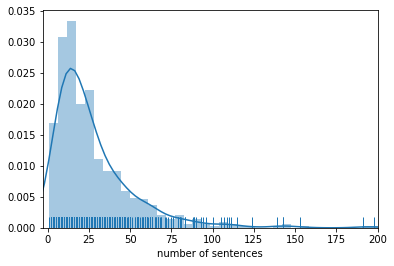

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Distribution of article sentence-length
plot = sns.distplot(num_sents_per_article, rug=True, axlabel='number of sentences')
plt.xlim(-3, 200)
plot.get_figure().savefig('hyperpartisan.article-sentence-length.png', dpi=200)

In [17]:
## Percentage of cropped articles
import numpy as np
art_sent_len_cutoff = 50
num_cutoff = np.count_nonzero(np.array(num_sents_per_article) > art_sent_len_cutoff)
print('Percentage of cut articles: {:%} (cutoff at {})'.format(num_cutoff / len(num_sents_per_article), art_sent_len_cutoff))

art_sent_len_cutoff = 200
num_cutoff = np.count_nonzero(np.array(num_sents_per_article) > art_sent_len_cutoff)
print('Percentage of cut articles: {:%} (cutoff at {})'.format(num_cutoff / len(num_sents_per_article), art_sent_len_cutoff))

Percentage of cut articles: 12.713178% (cutoff at 50)
Percentage of cut articles: 0.155039% (cutoff at 200)


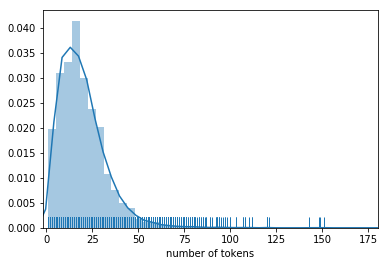

In [18]:
## Distribution of sentence token-length
plot = sns.distplot(num_tokens_per_sent, rug=True, axlabel='number of tokens', bins=100)
plt.xlim(-2, 180)
plot.get_figure().savefig('hyperpartisan.sentence-token-length.png', dpi=200)

In [19]:
## Percentage of cropped sentences
import numpy as np
sent_token_len_cutoff = 50
num_cutoff = np.count_nonzero(np.array(num_tokens_per_sent) > sent_token_len_cutoff)
print('Percentage of cut articles: {:%} (cutoff at {})'.format(num_cutoff / len(num_tokens_per_sent), sent_token_len_cutoff))

sent_token_len_cutoff = 200
num_cutoff = np.count_nonzero(np.array(num_tokens_per_sent) > sent_token_len_cutoff)
print('Percentage of cut articles: {:%} (cutoff at {})'.format(num_cutoff / len(num_tokens_per_sent), sent_token_len_cutoff))

Percentage of cut articles: 2.308851% (cutoff at 50)
Percentage of cut articles: 0.033462% (cutoff at 200)


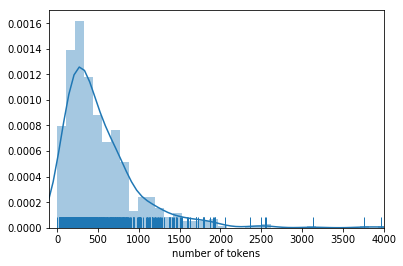

In [20]:
## Distribution of article token-length
plot = sns.distplot(num_tokens_per_article, rug=True, axlabel='number of tokens')
plt.xlim(-100, 4000)
plot.get_figure().savefig('hyperpartisan.article-token-length.png', dpi=200)

In [21]:
## Percentage of cropped articles
import numpy as np
art_token_len_cutoff = 500
num_cutoff = np.count_nonzero(np.array(num_tokens_per_article) > art_token_len_cutoff)
print('Percentage of cut articles: {:%} (cutoff at {})'.format(num_cutoff / len(num_tokens_per_article), art_token_len_cutoff))

Percentage of cut articles: 38.914729% (cutoff at 500)


In [ ]:

### ## Old code below ## ###


In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

hyperpartisan_vals = [len(sent_tokenize(a.get_text())) for a in hyperpartisan]
#print('Percentage HYPERPARTISAN articles trimmed: {:.2%}'.format((len(hyperpartisan) - len(hyperpartisan_vals)) / len(hyperpartisan)))

mainstream_vals = [len(sent_tokenize(a.get_text())) for a in mainstream]
#print('Percentage MAINSTREAM articles trimmed: {:.2%}'.format((len(mainstream) - len(mainstream_vals)) / len(mainstream)))

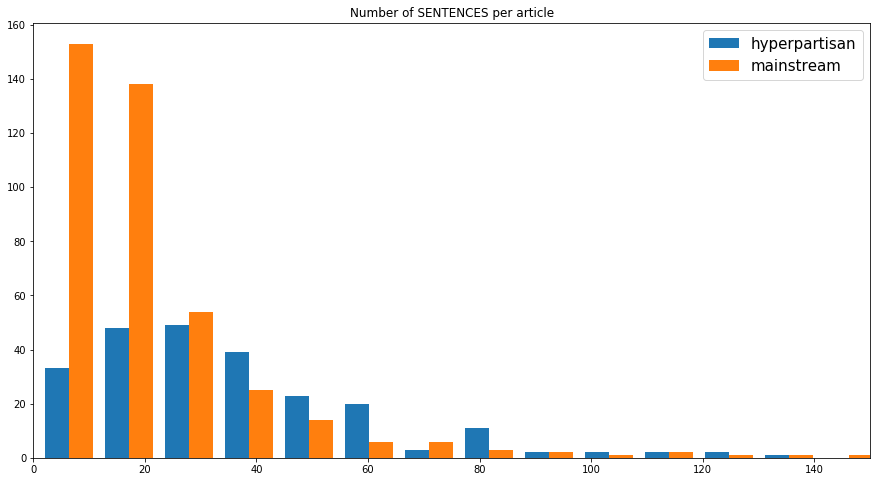

<Figure size 432x288 with 0 Axes>

In [10]:
plt.hist([hyperpartisan_vals, mainstream_vals], bins=20, label=['hyperpartisan', 'mainstream'])
plt.legend(loc='upper right', prop={'size': 15})
plt.title('Number of SENTENCES per article')

fig = plt.gcf()
fig.set_size_inches(15, 8)

plt.xlim(0, 150)
plt.show()
plt.clf()

In [11]:
print('Hyperpartisan Avg num_sents:', sum(hyperpartisan_vals) / len(hyperpartisan_vals))
print('Mainstream Avg num_sents:', sum(mainstream_vals) / len(mainstream_vals))

Hyperpartisan Avg num_sents: 37.49579831932773
Mainstream Avg num_sents: 20.412776412776413


In [12]:
%matplotlib inline
from nltk.tokenize import word_tokenize

hyperpartisan_num_words = [len(word_tokenize(a.get_text())) for a in hyperpartisan]
#print('Percentage HYPERPARTISAN articles trimmed: {:.2%}'.format((len(hyperpartisan) - len(hyperpartisan_vals)) / len(hyperpartisan)))

mainstream_num_words = [len(word_tokenize(a.get_text())) for a in mainstream]
#print('Percentage MAINSTREAM articles trimmed: {:.2%}'.format((len(mainstream) - len(mainstream_vals)) / len(mainstream)))

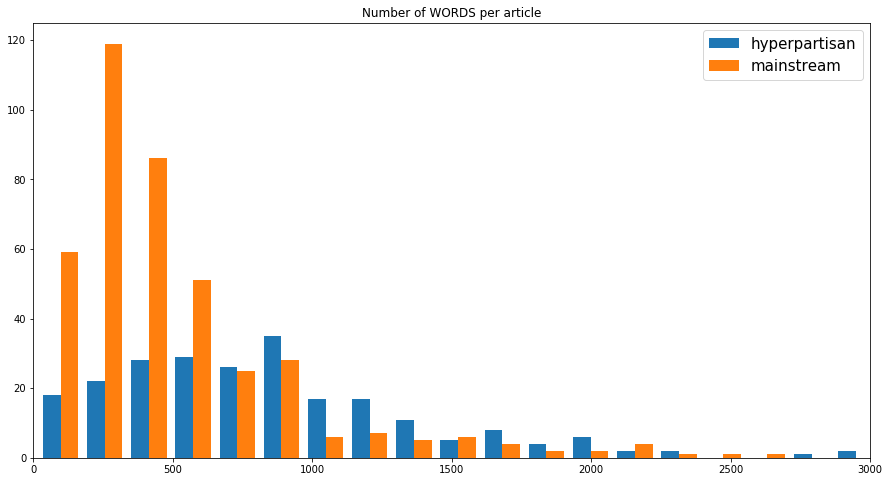

<Figure size 432x288 with 0 Axes>

In [13]:
plt.hist([hyperpartisan_num_words, mainstream_num_words], bins=40, label=['hyperpartisan', 'mainstream'])
plt.legend(loc='upper right', prop={'size': 15})
plt.title('Number of WORDS per article')

fig = plt.gcf()
fig.set_size_inches(15, 8)

plt.xlim(0, 3000)
plt.show()
plt.clf()

In [14]:
print('Hyperpartisan Avg number of words:', sum(hyperpartisan_num_words) / len(hyperpartisan_num_words))
print('Mainstream Avg number of words:', sum(mainstream_num_words) / len(mainstream_num_words))

Hyperpartisan Avg number of words: 929.436974789916
Mainstream Avg number of words: 505.9312039312039


In [15]:
hyperpartisan_num_links = [sum(map(lambda e: 1 if e.tag == 'a' else 0, list(a.root.iter()))) for a in hyperpartisan]
mainstream_num_links = [sum(map(lambda e: 1 if e.tag == 'a' else 0, list(a.root.iter()))) for a in mainstream]

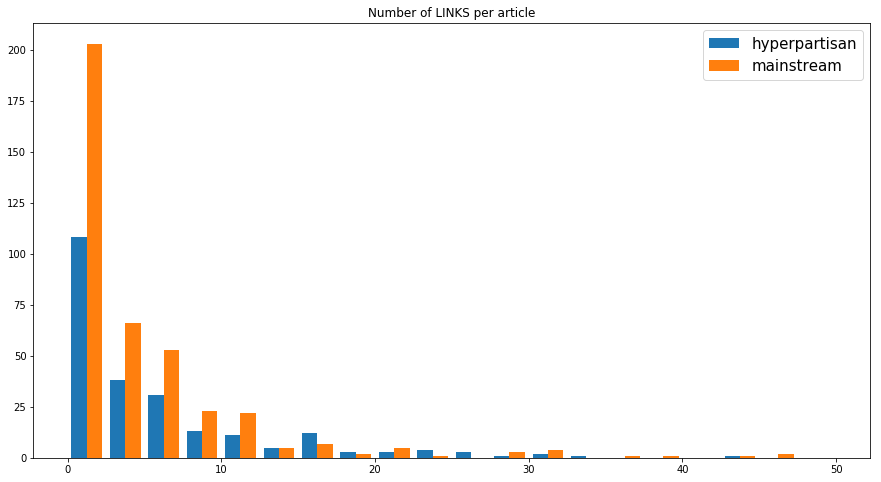

In [16]:
plt.hist([hyperpartisan_num_links, mainstream_num_links], bins=20, label=['hyperpartisan', 'mainstream'], range=(0, 50), align='mid')
plt.legend(loc='upper right', prop={'size': 15})
plt.title('Number of LINKS per article')

fig = plt.gcf()
fig.set_size_inches(15, 8)

plt.show()

In [17]:
hyperpartisan_tf = dict()
for a in hyperpartisan:
    for word in a.get_text_cleaned().split(' '):
        if word in hyperpartisan_tf:
            hyperpartisan_tf[word] += 1
        else:
            hyperpartisan_tf[word] = 1

In [18]:
mainstream_tf = dict()
for a in mainstream:
    for word in a.get_text_cleaned().split(' '):
        if word in mainstream_tf:
            mainstream_tf[word] += 1
        else:
            mainstream_tf[word] = 1

In [19]:
import operator
sorted_hyp_tf = sorted(hyperpartisan_tf.items(), key=operator.itemgetter(1), reverse=True)
sorted_main_tf = sorted(mainstream_tf.items(), key=operator.itemgetter(1), reverse=True)

In [20]:
sorted_hyp_tf = sorted_hyp_tf[:1000]
sorted_main_tf = sorted_main_tf[:1000]

In [21]:
hyp_tf_cropped = {e[0]: e[1] for e in sorted_hyp_tf}
main_tf_cropped = {e[0]: e[1] for e in sorted_main_tf}

In [22]:
for w in set(hyp_tf_cropped.keys()):
    if w in main_tf_cropped:
        del main_tf_cropped[w]

In [23]:
for w in set(main_tf_cropped.keys()):
    if w in hyp_tf_cropped:
        print('deleting '+ w)
        del hyp_tf_cropped[w]